# Stress Analysis

This example demonstrates how to undertake stress analyses and view their results. We start by importing the necessary modules.

In [1]:
import numpy as np
from rich.pretty import pprint
from concreteproperties.material import Concrete, SteelBar
from concreteproperties.stress_strain_profile import (
    EurocodeNonLinear,
    RectangularStressBlock,
    SteelElasticPlastic,
)
from sectionproperties.pre.library.concrete_sections import concrete_circular_section
from concreteproperties.concrete_section import ConcreteSection

## Assign Materials
The materials used in this example will be 40 MPa concrete and 500 MPa steel, specified in accordance with AS 3600:2018. The service stress-strain profile for the concrete will be adapted from EC2.

In [2]:
concrete = Concrete(
    name="40 MPa Concrete",
    density=2.4e-6,
    stress_strain_profile=EurocodeNonLinear(
        elastic_modulus=32.8e3,
        ultimate_strain=0.0035,
        compressive_strength=40,
        compressive_strain=0.0023,
        tensile_strength=3.8,
        tension_softening_stiffness=10e3,
    ),
    ultimate_stress_strain_profile=RectangularStressBlock(
        compressive_strength=40,
        alpha=0.79,
        gamma=0.87,
        ultimate_strain=0.003,
    ),
    flexural_tensile_strength=3.8,
    colour="lightgrey",
)

steel = SteelBar(
    name="500 MPa Steel",
    density=7.85e-6,
    stress_strain_profile=SteelElasticPlastic(
        yield_strength=500,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="grey",
)

## Create Geometry and Concrete Section
The section in this example is a 600 mm diameter concrete column, reinforced with 10N20 bars with 45 mm cover. The geometry is generated using the *sectionproperties* concrete sections library.

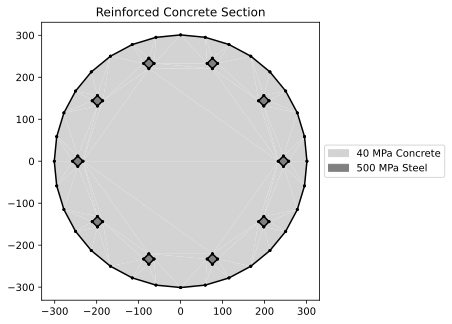

<AxesSubplot: title={'center': 'Reinforced Concrete Section'}>

In [3]:
geom = concrete_circular_section(
    d=600,
    n=32,
    dia=20,
    n_bar=10,
    n_circle=4,
    area_conc=np.pi * 600 * 600 / 4,
    area_bar=310,
    cover=45,
    conc_mat=concrete,
    steel_mat=steel,
)

conc_sec = ConcreteSection(geom)
conc_sec.plot_section()

## Elastic Uncracked Stress Analysis
We perform an uncracked stress analysis using the ``calculate_uncracked_stress()`` method. This analysis assumes the entire concrete section acts to resist the applied loading. Note that *concreteproperties* does not check to see if the provided moment is above the cracking moment, this should be confirmed by performing a cracking analysis.

In [4]:
uncr_stress_res_1 = conc_sec.calculate_uncracked_stress(m_x=50e6)
uncr_stress_res_2 = conc_sec.calculate_uncracked_stress(m_x=25e6, m_y=35e6, n=200e3)

We can visualise the stresses by calling the ``plot_stress()`` method.

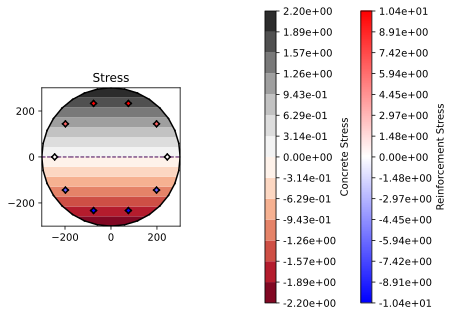

<AxesSubplot: title={'center': 'Stress'}>

In [5]:
uncr_stress_res_1.plot_stress()

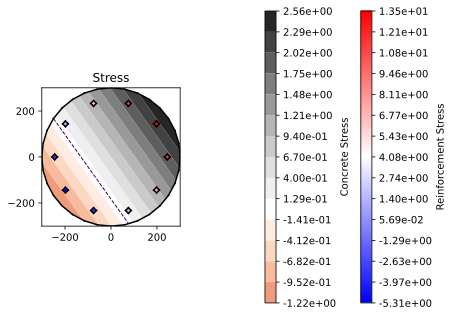

<AxesSubplot: title={'center': 'Stress'}>

In [6]:
uncr_stress_res_2.plot_stress()

## Elastic Cracked Stress Analysis
A cracked stress analysis first requires a cracking analysis to be performed by calling the ``calculate_cracked_properties()`` method. Here we perform a cracking analysis for bending about the ``x`` axis.

In [7]:
cracked_res = conc_sec.calculate_cracked_properties(theta=0)
print(f"M_cr = {cracked_res.m_cr / 1e6:.2f} kN.m")
print(f"d_n,c = {cracked_res.d_nc:.2f} mm")

M_cr = 86.32 kN.m
d_n,c = 143.81 mm


Since the cracking moment is 86 kN.m, let's see what the stresses within the cross-section look like under 150 kN.m bending moment. Note that the moment will be applied about the same axis as used in the cracking analysis.

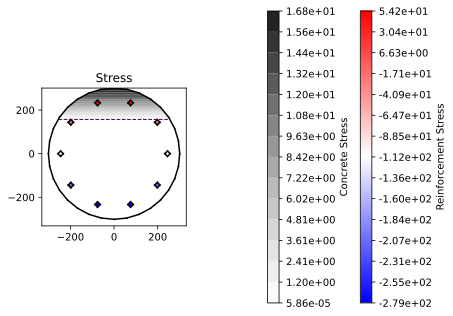

<AxesSubplot: title={'center': 'Stress'}>

In [8]:
m_ext = 150e6
cracked_stress_res = conc_sec.calculate_cracked_stress(
    cracked_results=cracked_res, m=m_ext
)
cracked_stress_res.plot_stress()

Many useful results are stored within the ``StressResult`` object. Let's examine a few of these results.

### Concrete Results
Concrete geometries that remain after cracking are stored in the ``concrete_analysis_sections`` attribute as a list of ``AnalysisSection`` objects. We can visualise this geometry by calling the ``plot_mesh()`` method. The ``StressResult`` object also stores the stresses at the nodes in each ``AnalysisSection`` in the ``concrete_stresses`` attribute - these are the stresses you see on the ``plot_stress()`` plots. Finally, the ``concrete_forces`` attribute stores the resultant force for each ``AnalysisSection`` and its lever arm to the cracked centroid.

Analysis Section 1


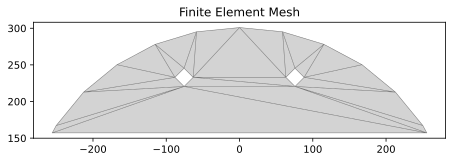

Concrete Stresses:


array([5.86428608e-05, 1.17773025e+00, 6.52033249e+00, 1.09048928e+01,
│      1.41629151e+01, 1.61691954e+01, 1.68466333e+01, 1.61691954e+01,
│      1.41629151e+01, 1.09048928e+01, 6.52033249e+00, 1.17773025e+00,
│      5.86428608e-05, 8.88584105e+00, 1.03442623e+01, 8.88584105e+00,
│      7.42741992e+00, 7.42741992e+00, 8.88584105e+00, 1.03442623e+01,
│      8.88584105e+00])

Concrete Net Force & Lever Arm:
F_c = 347.99 kN
d_x_n = -0.00 mm
d_y_n = 82.77 mm
M_x_c = 28.80 kN.m
M_y_c = -0.00 kN.m
M_c = 28.80 kN.m


In [9]:
for idx, an_sec in enumerate(cracked_stress_res.concrete_analysis_sections):
    # Label section and plot section mesh
    print(f"Analysis Section {idx + 1}")
    an_sec.plot_mesh()

    # get concrete results
    sigs_conc = cracked_stress_res.concrete_stresses[idx]
    f_conc = cracked_stress_res.concrete_forces[idx][0]
    d_x_conc = cracked_stress_res.concrete_forces[idx][1]
    d_y_conc = cracked_stress_res.concrete_forces[idx][2]
    m_x_conc = f_conc * d_y_conc
    m_y_conc = f_conc * d_x_conc
    m_conc = np.sqrt(m_x_conc * m_x_conc + m_y_conc * m_y_conc)

    # print results
    print("Concrete Stresses:")
    pprint(sigs_conc)
    print("Concrete Net Force & Lever Arm:")
    print(f"F_c = {f_conc / 1e3:.2f} kN")
    print(f"d_x_n = {d_x_conc:.2f} mm")
    print(f"d_y_n = {d_y_conc:.2f} mm")
    print(f"M_x_c = {m_x_conc / 1e6:.2f} kN.m")
    print(f"M_y_c = {m_y_conc / 1e6:.2f} kN.m")
    print(f"M_c = {m_conc / 1e6:.2f} kN.m")

### Reinforcement Results
Lumped reinforcement geometries are stored in the ``lumped_reinforcement_geometries`` attribute of the ``StressResult`` object. Similar to the concrete results, the stresses and forces/lever arms are stored, as well as the strains. Here we print the stress for each lumped bar to the terminal. Note that meshed reinforcement results are also stored, but have not been used for this analysis.

In [10]:
from rich.table import Table
from rich.console import Console

# store forces & moments for later
forces = []
moments_x = []

# create a Rich table for pretty printing
table = Table(title="Reinforcement Results")
table.add_column("Bar No.", justify="center", style="cyan", no_wrap=True)
table.add_column("Location (x, y) (mm)", justify="center", style="green")
table.add_column("Stress (MPa)", justify="center", style="green")
table.add_column("Force (kN)", justify="center", style="green")
table.add_column("Lever Arm (mm)", justify="center", style="green")
table.add_column("Moment (kN.m)", justify="center", style="green")

for idx, reinf_geom in enumerate(cracked_stress_res.lumped_reinforcement_geometries):
    # get the reinforcement results
    centroid = reinf_geom.calculate_centroid()
    stress = cracked_stress_res.lumped_reinforcement_stresses[idx]
    strain = cracked_stress_res.lumped_reinforcement_strains[idx]
    force, d_x, d_y = cracked_stress_res.lumped_reinforcement_forces[idx]

    # calculate the moment each bar creates and store the results
    moment_x = force * d_y
    forces.append(force)
    moments_x.append(moment_x)

    # print compression or tension
    if strain > 0:
        t_or_c = "C"
    else:
        t_or_c = "T"

    table.add_row(
        f"{idx + 1}",
        f"({centroid[0]:.1f}, {centroid[1]:.1f})",
        f"{abs(stress):.1f} ({t_or_c})",
        f"{abs(force) / 1e3:.1f}",
        f"{d_y:.1f}",
        f"{moment_x / 1e6:.2f}",
    )

console = Console()
console.print(table)

                                     Reinforcement Results                                     
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Bar No. ┃ Location (x, y) (mm) ┃ Stress (MPa) ┃ Force (kN) ┃ Lever Arm (mm) ┃ Moment (kN.m) ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│    1    │    (245.0, -0.0)     │  112.3 (T)   │    34.8    │     -157.2     │     5.47      │
│    2    │    (198.2, 144.0)    │   9.4 (T)    │    2.9     │     -13.1      │     0.04      │
│    3    │    (75.7, 233.0)     │   54.2 (C)   │    16.8    │      75.9      │     1.27      │
│    4    │    (-75.7, 233.0)    │   54.2 (C)   │    16.8    │      75.9      │     1.27      │
│    5    │   (-198.2, 144.0)    │   9.4 (T)    │    2.9     │     -13.1      │     0.04      │
│    6    │    (-245.0, -0.0)    │  112.3 (T)   │    34.8    │     -157.2     │     5.47      │
│    7    │   (-198.2, -144.0)   │  215.1 (T)   │    66.7    │     -301.2     │     20.08     │
│    8    │   (-75.7, -233.0)    │  278.7 (T)   │    86.4    │     -390.2     │     33.71     │
│    9    │    (75.7, -233.0)    │  278.7 (T)   │    86.4    │     -390.2     │     33.71     │
│   10    │   (198.2, -144.0)    │  215.1 (T)   │    66.7    │     -301.2     │     20.08     │
└─────────┴──────────────────────┴──────────────┴────────────┴────────────────┴───────────────┘

Finally, let's confirm that the net axial force is indeed zero and the internal moment is equal to the external moment.

In [11]:
# sum of forces
int_force = sum(forces) + f_conc
print(f"Sum of Internal Forces: {int_force / 1e3:.0f} kN")

# sum of moments
int_moment = sum(moments_x) + m_conc
print(f"Sum of Internal Moments: {int_moment / 1e6:.0f} kN.m")
print(f"External Moment: {m_ext / 1e6:.0f} kN.m")

Sum of Internal Forces: 0 kN
Sum of Internal Moments: 150 kN.m
External Moment: 150 kN.m


## Service Stress Analysis
A service stress analysis displays internal stresses based off the stress-strain profiles provided to the material properties. Before viewing the stresses, a moment curvature analysis must be performed to establish the structural response of the reinforced concrete section.

In [12]:
mk_res = conc_sec.moment_curvature_analysis()

Output()

Let's plot the moment curvature diagram so that we can choose some interesting points to generate stress results.

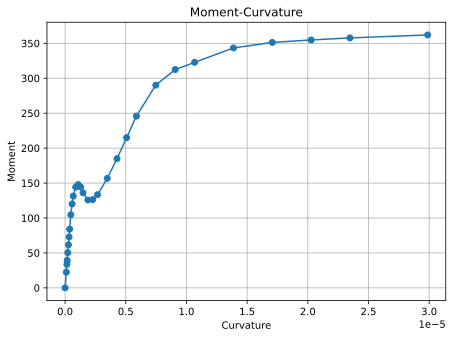

<AxesSubplot: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [13]:
mk_res.plot_results()

Based on the above, we compile a list of moments and curvatures at which we want to visualise the cross-section stresses. We use curvatures as input around the softening region as there are two possible values of moment.

In [14]:
# create a list of inputs (either moments [m] or curvatures [k])
stress_inputs = [
    {"m_or_k": "m", "val": 50e6},
    {"m_or_k": "m", "val": cracked_res.m_cr},
    {"m_or_k": "k", "val": 7.5e-07},
    {"m_or_k": "k", "val": 1.15e-06},
    {"m_or_k": "k", "val": 2.15e-06},
    {"m_or_k": "m", "val": 250e6},
    {"m_or_k": "m", "val": 300e6},
    {"m_or_k": "m", "val": 360e6},
]

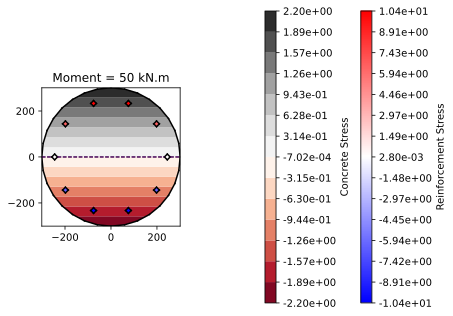

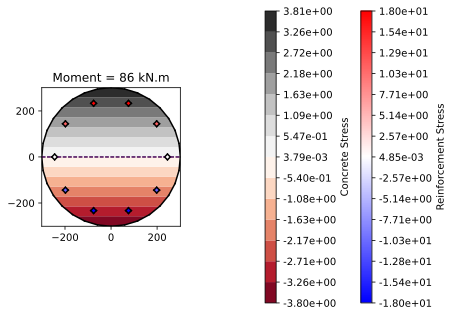

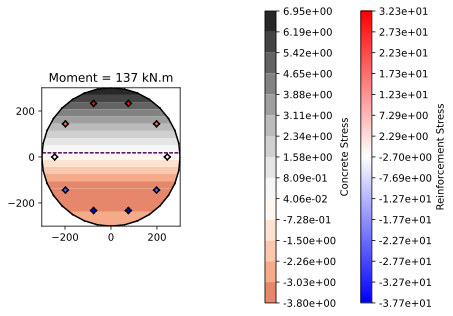

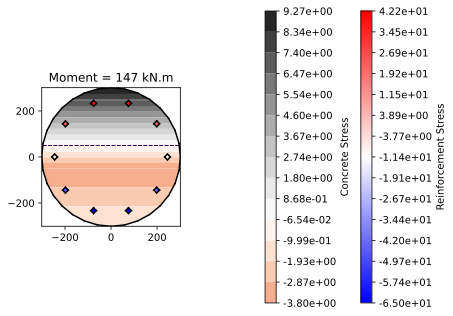

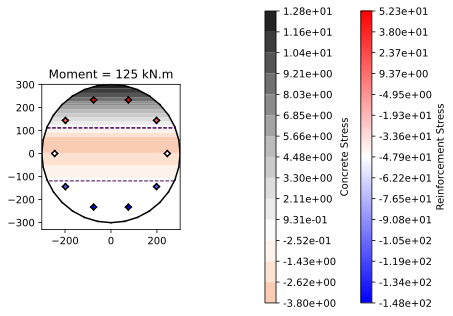

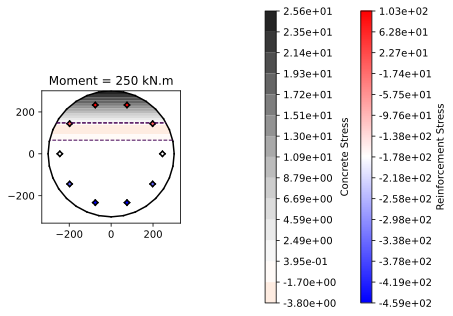

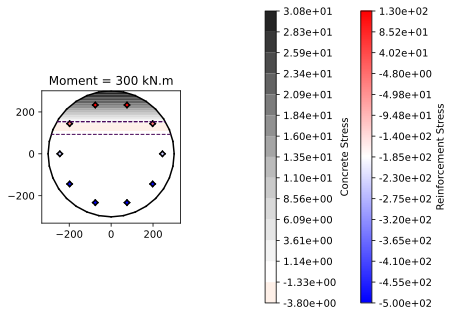

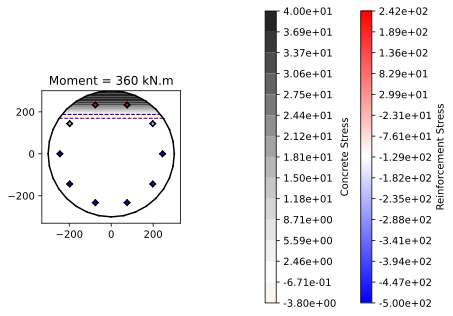

In [15]:
# loop through each input
for s_in in stress_inputs:
    # determine if the input is a moment or curvature
    if s_in["m_or_k"] == "m":
        m_stress = s_in["val"]
        service_stress_res = conc_sec.calculate_service_stress(
            moment_curvature_results=mk_res, m=m_stress
        )
    elif s_in["m_or_k"] == "k":
        service_stress_res = conc_sec.calculate_service_stress(
            moment_curvature_results=mk_res, m=None, kappa=s_in["val"]
        )
        m_stress = service_stress_res.sum_moments()[2]

    # create plot title and plot stress
    label = f"Moment = {m_stress / 1e6:.0f} kN.m"
    service_stress_res.plot_stress(title=label)

Viewing the above stress plots in combination with the moment curvature diagram is an insightful way of understanding the bending response of a reinforced concrete section!

## Ultimate Stress Analysis
An ultimate stress analysis displayed the internal stresses at the ultimate bending moment. In this example we examine the ultimate stresses at the pure bending point, the balanced point and the decompression point. To locate these points we first plot the moment interaction diagram.

Output()

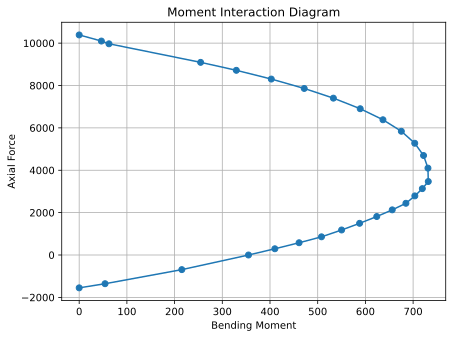

<AxesSubplot: title={'center': 'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [16]:
mi_res = conc_sec.moment_interaction_diagram()
mi_res.plot_diagram()

Prior to plotting the stresses, the ultimate bending capacities must be calculated.

In [17]:
ultimate_res_pure = conc_sec.ultimate_bending_capacity()
ultimate_res_bal = conc_sec.ultimate_bending_capacity(n=3500e3)
ultimate_res_decomp = conc_sec.ultimate_bending_capacity(n=9000e3)

We calculate the ultimate stresses by calling the ``calculate_ultimate_stress()`` method.

In [18]:
ultimate_stress_pure = conc_sec.calculate_ultimate_stress(
    ultimate_results=ultimate_res_pure
)
ultimate_stress_bal = conc_sec.calculate_ultimate_stress(
    ultimate_results=ultimate_res_bal
)
ultimate_stress_decomp = conc_sec.calculate_ultimate_stress(
    ultimate_results=ultimate_res_decomp
)

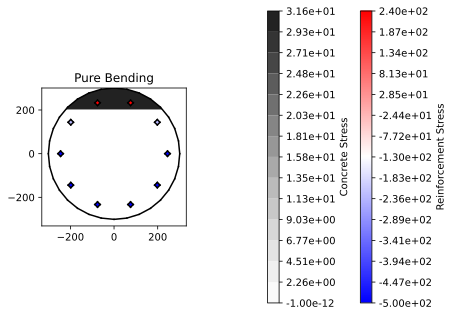

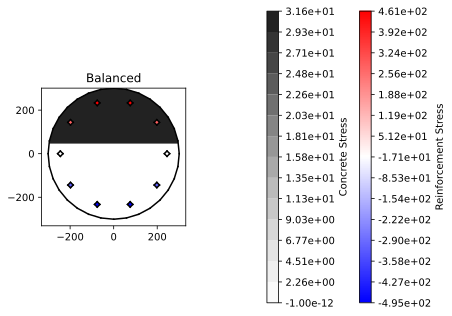

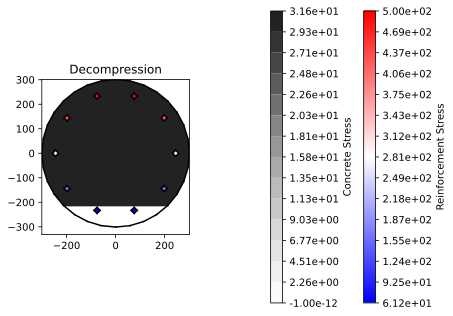

<AxesSubplot: title={'center': 'Decompression'}>

In [19]:
ultimate_stress_pure.plot_stress(title="Pure Bending")
ultimate_stress_bal.plot_stress(title="Balanced")
ultimate_stress_decomp.plot_stress(title="Decompression")

As a rectangular stress block is used for the ultimate stress-strain profile, the entire cross-section is not in compression due to the zero stress region above the neutral axis in the stress-strain profile.